In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
from lmfit.models import GaussianModel


In [ ]:
data_test = np.loadtxt('Test_30V_0_5V_166C_6V.txt', skiprows = 5)
dataA2 = np.loadtxt('A_40V_2V_166C.txt', skiprows = 5)
dataA2_5 = np.loadtxt('A_40V_2_5V_165C.txt', skiprows = 5)
dataA3 = np.loadtxt('A_40V_3V_165C.txt', skiprows = 5)
dataA3_5 = np.loadtxt('A_40V_3_5V_165C.txt', skiprows = 5)
dataA4 = np.loadtxt('A_40V_4V_165C.txt', skiprows = 5)

dataB165 = np.loadtxt('B_40V_3V_165C.txt', skiprows = 5)
dataB170 = np.loadtxt('B_40V_3V_170C.txt', skiprows = 5)
dataB175 = np.loadtxt('B_40V_3V_175C.txt', skiprows = 5)
dataB180 = np.loadtxt('B_40V_3V_180C.txt', skiprows = 5)


print(data_test)

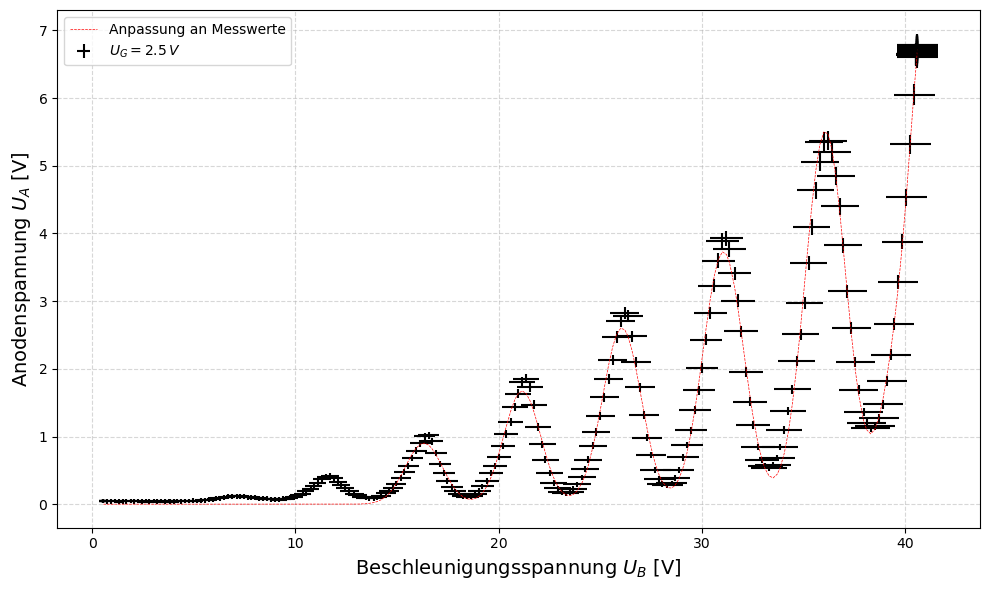

Individual σ values:
  σ_01 = 0.675 V
  σ_02 = 1.000 V
  σ_03 = 1.000 V
  σ_04 = 1.000 V
  σ_05 = 0.949 V
  σ_06 = 0.903 V
  σ_07 = 0.917 V

Mean σ = 0.921 V
Std. dev. of σ = 0.107 V

Peak spacings ΔU_B_A2_5 between successive centers:
  ΔU_01 = 4.800 V
  ΔU_02 = 4.850 V
  ΔU_03 = 5.000 V
  ΔU_04 = 5.000 V
  ΔU_05 = 4.400 V

Mean ΔU_B_A2_5 = 4.810 V
Std. dev. ΔU_B_A2_5 = 0.220 V

ΔE_A2_5 = 7.706e-19 J = 4.810 eV
Std. dev. ΔE_A2_5 = 3.525e-20 J = 0.220 eV
THIS IS FOR 2.5V


In [140]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from lmfit.models import GaussianModel

# 1) Load your data (custom naming)
dataA2_5 = np.loadtxt("A_40V_2_5V_165C.txt", skiprows=5)
UB_A2_5 = dataA2_5[:, 2]   # "Acceleration voltage" U_B
UA_A2_5 = dataA2_5[:, 1]   # "Anode voltage"      U_A

# 2) Uncertainties (2% + small floor)
UBerr = 0.02 * UB_A2_5 + 0.005 * np.ptp(UB_A2_5)
UAerr = 0.02 * UA_A2_5 + 0.005 * np.ptp(UA_A2_5)

# 3) Automatically find peaks in the data
peaks, props = find_peaks(UA_A2_5, height=0.1 * UA_A2_5.max(), distance=20)
peak_centers = UB_A2_5[peaks]
peak_amps    = props["peak_heights"]

# 4) Build a sum‐of‐Gaussians model, one Gaussian per detected peak
model = None
params = None
for i, (cen, amp) in enumerate(zip(peak_centers, peak_amps)):
    prefix = f'g{i}_'
    gauss  = GaussianModel(prefix=prefix)
    if model is None:
        model = gauss
        params = gauss.make_params()
    else:
        model += gauss
        params.update(gauss.make_params())

    # initialize and constrain
    params[prefix + 'center'].set(value=cen,   min=cen-0.5, max=cen+0.5)
    params[prefix + 'amplitude'].set(value=amp, min=0)
    params[prefix + 'sigma'].set(value=0.3,   min=0.05, max=1.0)

# 5) Fit with 1/σ weighting → chi-square minimization
weights = 1.0 / UAerr
result  = model.fit(UA_A2_5, params, x=UB_A2_5, weights=weights)

# 6) Plot data + fit
plt.figure(figsize=(10,6))
plt.errorbar(UB_A2_5, UA_A2_5,
             xerr=UBerr, yerr=UAerr,
             fmt='+', ms=0.1, color='black', alpha=1,
             label=r'$U_G=2.5\,V$')
plt.plot(UB_A2_5, result.best_fit,
         'r--', lw=0.5, label='Anpassung an Messwerte')
plt.xlabel('Beschleunigungsspannung $U_B$ [V]', fontsize=14)
plt.ylabel('Anodenspannung $U_A$ [V]',        fontsize=14)
#plt.title('Franck–Hertz: Multi‐Gaussian Fit', fontsize=16)
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"UG2_5.png", dpi=1000)
plt.show()

# 7) Extract and report σ's
sigmas = [v for k,v in result.best_values.items() if k.endswith('sigma')]
mean_s, std_s = np.mean(sigmas), np.std(sigmas)
print("Individual σ values:")
for i, s in enumerate(sigmas, 1):
    print(f"  σ_{i:02d} = {s:.3f} V")
print(f"\nMean σ = {mean_s:.3f} V")
print(f"Std. dev. of σ = {std_s:.3f} V")

# 8) Compute successive peak–to–peak spacings ΔU_B, drop any zero‐valued spacing
Delta_U_B_A2_5 = np.diff(peak_centers)
Delta_U_B_A2_5 = Delta_U_B_A2_5[Delta_U_B_A2_5 != 0]  # ignore zero spacings

print("\nPeak spacings ΔU_B_A2_5 between successive centers:")
for i, d in enumerate(Delta_U_B_A2_5, 1):
    print(f"  ΔU_{i:02d} = {d:.3f} V")

# 9) Mean and std deviation of spacing
mean_Delta_U = np.mean(Delta_U_B_A2_5)
std_Delta_U  = np.std(Delta_U_B_A2_5)
print(f"\nMean ΔU_B_A2_5 = {mean_Delta_U:.3f} V")
print(f"Std. dev. ΔU_B_A2_5 = {std_Delta_U:.3f} V")

# 10) Convert to energy
e_charge = 1.602176634e-19  # C
Delta_E_A2_5_J   = e_charge * mean_Delta_U
Std_Delta_E_A2_5_J = e_charge * std_Delta_U
Delta_E_A2_5_eV  = mean_Delta_U        # 1 V × e = 1 eV
Std_Delta_E_A2_5_eV = std_Delta_U

print(f"\nΔE_A2_5 = {Delta_E_A2_5_J:.3e} J = {Delta_E_A2_5_eV:.3f} eV")
print(f"Std. dev. ΔE_A2_5 = {Std_Delta_E_A2_5_J:.3e} J = {Std_Delta_E_A2_5_eV:.3f} eV")

print("THIS IS FOR 2.5V")
# after printing the values on screen, write them to disk:
#with open(f"UG2_5_summary.txt", "w") as fout:
 #       fout.write(f"File: {label}\n\n")
  #      fout.write(f"Mean σ      = {np.mean(sigmas):.3f} V\n")
   #     fout.write(f"Std  σ      = {np.std(sigmas):.3f} V\n\n")
    #    fout.write(f"Mean ΔU     = {mean_dU:.3f} V\n")
    #    fout.write(f"Std  ΔU     = {std_dU:.3f} V\n\n")
    #    fout.write(f"Mean ΔE     = {dE_eV:.3f} eV\n")
    #    fout.write(f"Std  ΔE     = {std_dE_eV:.3f} eV\n")


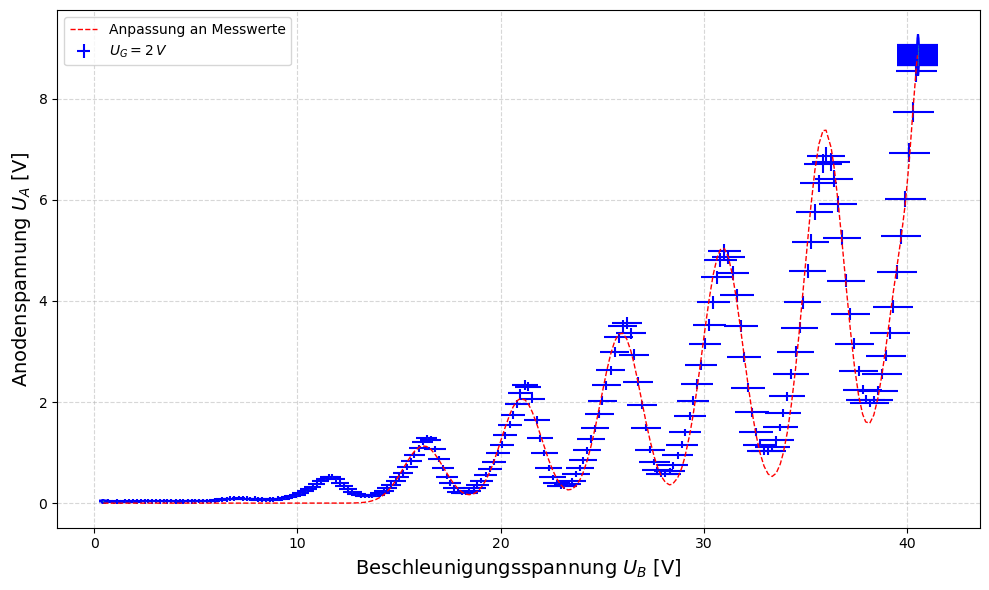

Individual σ values:
  σ_01 = 0.432 V
  σ_02 = 0.101 V
  σ_03 = 1.000 V
  σ_04 = 1.000 V
  σ_05 = 1.000 V
  σ_06 = 1.000 V
  σ_07 = 1.000 V
  σ_08 = 1.000 V

Mean σ = 0.817 V
Std. dev. of σ = 0.328 V

Peak spacings ΔU_B_A2_5 between successive centers:
  ΔU_01 = 4.850 V
  ΔU_02 = 5.000 V
  ΔU_03 = 4.800 V
  ΔU_04 = 5.000 V
  ΔU_05 = 4.500 V

Mean ΔU_B_A2_5 = 4.830 V
Std. dev. ΔU_B_A2_5 = 0.183 V

ΔE_A2_5 = 7.739e-19 J = 4.830 eV
Std. dev. ΔE_A2_5 = 2.937e-20 J = 0.183 eV
THIS IS FOR 2V


In [148]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from lmfit.models import GaussianModel

# 1) Load your data (custom naming)
dataA2 = np.loadtxt('A_40V_2V_166C.txt', skiprows = 5)

UB_A2_5 = dataA2[:, 2]   # "Acceleration voltage" U_B
UA_A2_5 = dataA2[:, 1]   # "Anode voltage"      U_A

# 2) Uncertainties (2% + small floor)
UBerr = 0.02 * UB_A2_5 + 0.005 * np.ptp(UB_A2_5)
UAerr = 0.02 * UA_A2_5 + 0.005 * np.ptp(UA_A2_5)

# 3) Automatically find peaks in the data
peaks, props = find_peaks(UA_A2_5, height=0.1 * UA_A2_5.max(), distance=20)
peak_centers = UB_A2_5[peaks]
peak_amps    = props["peak_heights"]

# 4) Build a sum‐of‐Gaussians model, one Gaussian per detected peak
model = None
params = None
for i, (cen, amp) in enumerate(zip(peak_centers, peak_amps)):
    prefix = f'g{i}_'
    gauss  = GaussianModel(prefix=prefix)
    if model is None:
        model = gauss
        params = gauss.make_params()
    else:
        model += gauss
        params.update(gauss.make_params())

    # initialize and constrain
    params[prefix + 'center'].set(value=cen,   min=cen-0.5, max=cen+0.5)
    params[prefix + 'amplitude'].set(value=amp, min=0)
    params[prefix + 'sigma'].set(value=0.3,   min=0.05, max=1.0)

# 5) Fit with 1/σ weighting → chi-square minimization
weights = 1.0 / UAerr
result  = model.fit(UA_A2_5, params, x=UB_A2_5, weights=weights)

# 6) Plot data + fit
plt.figure(figsize=(10,6))
plt.errorbar(UB_A2_5, UA_A2_5,
             xerr=UBerr, yerr=UAerr,
             fmt='+', ms=0.1, ecolor='blue', alpha=1,
             label=r'$U_G=2\,V$')
plt.plot(UB_A2_5, result.best_fit,
         'r--', lw=1, label='Anpassung an Messwerte')
plt.xlabel('Beschleunigungsspannung $U_B$ [V]', fontsize=14)
plt.ylabel('Anodenspannung $U_A$ [V]',        fontsize=14)
#plt.title('Franck–Hertz: Multi‐Gaussian Fit', fontsize=16)
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"UG2.png", dpi=1000)
plt.show()

# 7) Extract and report σ's
sigmas = [v for k,v in result.best_values.items() if k.endswith('sigma')]
mean_s, std_s = np.mean(sigmas), np.std(sigmas)
print("Individual σ values:")
for i, s in enumerate(sigmas, 1):
    print(f"  σ_{i:02d} = {s:.3f} V")
print(f"\nMean σ = {mean_s:.3f} V")
print(f"Std. dev. of σ = {std_s:.3f} V")

# 8) Compute successive peak–to–peak spacings ΔU_B, drop any zero‐valued spacing
Delta_U_B_A2_5 = np.diff(peak_centers)
Delta_U_B_A2_5 = Delta_U_B_A2_5[Delta_U_B_A2_5 != 0]  # ignore zero spacings

print("\nPeak spacings ΔU_B_A2_5 between successive centers:")
for i, d in enumerate(Delta_U_B_A2_5, 1):
    print(f"  ΔU_{i:02d} = {d:.3f} V")

# 9) Mean and std deviation of spacing
mean_Delta_U = np.mean(Delta_U_B_A2_5)
std_Delta_U  = np.std(Delta_U_B_A2_5)
print(f"\nMean ΔU_B_A2_5 = {mean_Delta_U:.3f} V")
print(f"Std. dev. ΔU_B_A2_5 = {std_Delta_U:.3f} V")

# 10) Convert to energy
e_charge = 1.602176634e-19  # C
Delta_E_A2_5_J   = e_charge * mean_Delta_U
Std_Delta_E_A2_5_J = e_charge * std_Delta_U
Delta_E_A2_5_eV  = mean_Delta_U        # 1 V × e = 1 eV
Std_Delta_E_A2_5_eV = std_Delta_U

print(f"\nΔE_A2_5 = {Delta_E_A2_5_J:.3e} J = {Delta_E_A2_5_eV:.3f} eV")
print(f"Std. dev. ΔE_A2_5 = {Std_Delta_E_A2_5_J:.3e} J = {Std_Delta_E_A2_5_eV:.3f} eV")

print("THIS IS FOR 2V")


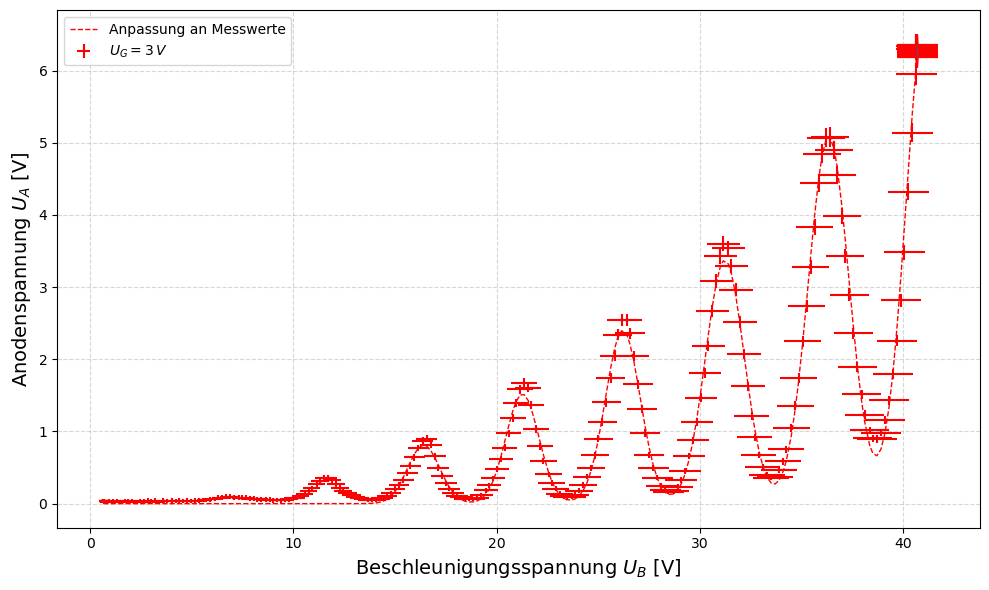

Individual σ values:
  σ_01 = 1.000 V
  σ_02 = 1.000 V
  σ_03 = 0.952 V
  σ_04 = 0.859 V
  σ_05 = 0.813 V
  σ_06 = 0.793 V

Mean σ = 0.903 V
Std. dev. of σ = 0.085 V

Peak spacings ΔU_B_A2_5 between successive centers:
  ΔU_01 = 4.800 V
  ΔU_02 = 5.050 V
  ΔU_03 = 4.750 V
  ΔU_04 = 5.250 V
  ΔU_05 = 4.300 V

Mean ΔU_B_A2_5 = 4.830 V
Std. dev. ΔU_B_A2_5 = 0.320 V

ΔE_A2_5 = 7.739e-19 J = 4.830 eV
Std. dev. ΔE_A2_5 = 5.132e-20 J = 0.320 eV
THIS IS FOR 3V


In [151]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from lmfit.models import GaussianModel

# 1) Load your data (custom naming)
dataA3 = np.loadtxt('A_40V_3V_165C.txt', skiprows = 5)


UB_A2_5 = dataA3[:, 2]   # "Acceleration voltage" U_B
UA_A2_5 = dataA3[:, 1]   # "Anode voltage"      U_A

# 2) Uncertainties (2% + small floor)
UBerr = 0.02 * UB_A2_5 + 0.005 * np.ptp(UB_A2_5)
UAerr = 0.02 * UA_A2_5 + 0.005 * np.ptp(UA_A2_5)

# 3) Automatically find peaks in the data
peaks, props = find_peaks(UA_A2_5, height=0.1 * UA_A2_5.max(), distance=20)
peak_centers = UB_A2_5[peaks]
peak_amps    = props["peak_heights"]

# 4) Build a sum‐of‐Gaussians model, one Gaussian per detected peak
model = None
params = None
for i, (cen, amp) in enumerate(zip(peak_centers, peak_amps)):
    prefix = f'g{i}_'
    gauss  = GaussianModel(prefix=prefix)
    if model is None:
        model = gauss
        params = gauss.make_params()
    else:
        model += gauss
        params.update(gauss.make_params())

    # initialize and constrain
    params[prefix + 'center'].set(value=cen,   min=cen-0.5, max=cen+0.5)
    params[prefix + 'amplitude'].set(value=amp, min=0)
    params[prefix + 'sigma'].set(value=0.3,   min=0.05, max=1.0)

# 5) Fit with 1/σ weighting → chi-square minimization
weights = 1.0 / UAerr
result  = model.fit(UA_A2_5, params, x=UB_A2_5, weights=weights)

# 6) Plot data + fit
plt.figure(figsize=(10,6))
plt.errorbar(UB_A2_5, UA_A2_5,
             xerr=UBerr, yerr=UAerr,
             fmt='+', ms=0.1, ecolor='red', alpha=1,
             label=r'$U_G=3\,V$')
plt.plot(UB_A2_5, result.best_fit,
         'r--', lw=1, label='Anpassung an Messwerte')
plt.xlabel('Beschleunigungsspannung $U_B$ [V]', fontsize=14)
plt.ylabel('Anodenspannung $U_A$ [V]',        fontsize=14)
#plt.title('Franck–Hertz: Multi‐Gaussian Fit', fontsize=16)
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"UG3.png", dpi=1000)
plt.show()

# 7) Extract and report σ's
sigmas = [v for k,v in result.best_values.items() if k.endswith('sigma')]
mean_s, std_s = np.mean(sigmas), np.std(sigmas)
print("Individual σ values:")
for i, s in enumerate(sigmas, 1):
    print(f"  σ_{i:02d} = {s:.3f} V")
print(f"\nMean σ = {mean_s:.3f} V")
print(f"Std. dev. of σ = {std_s:.3f} V")

# 8) Compute successive peak–to–peak spacings ΔU_B, drop any zero‐valued spacing
Delta_U_B_A2_5 = np.diff(peak_centers)
Delta_U_B_A2_5 = Delta_U_B_A2_5[Delta_U_B_A2_5 != 0]  # ignore zero spacings

print("\nPeak spacings ΔU_B_A2_5 between successive centers:")
for i, d in enumerate(Delta_U_B_A2_5, 1):
    print(f"  ΔU_{i:02d} = {d:.3f} V")

# 9) Mean and std deviation of spacing
mean_Delta_U = np.mean(Delta_U_B_A2_5)
std_Delta_U  = np.std(Delta_U_B_A2_5)
print(f"\nMean ΔU_B_A2_5 = {mean_Delta_U:.3f} V")
print(f"Std. dev. ΔU_B_A2_5 = {std_Delta_U:.3f} V")

# 10) Convert to energy
e_charge = 1.602176634e-19  # C
Delta_E_A2_5_J   = e_charge * mean_Delta_U
Std_Delta_E_A2_5_J = e_charge * std_Delta_U
Delta_E_A2_5_eV  = mean_Delta_U        # 1 V × e = 1 eV
Std_Delta_E_A2_5_eV = std_Delta_U

print(f"\nΔE_A2_5 = {Delta_E_A2_5_J:.3e} J = {Delta_E_A2_5_eV:.3f} eV")
print(f"Std. dev. ΔE_A2_5 = {Std_Delta_E_A2_5_J:.3e} J = {Std_Delta_E_A2_5_eV:.3f} eV")

print("THIS IS FOR 3V")


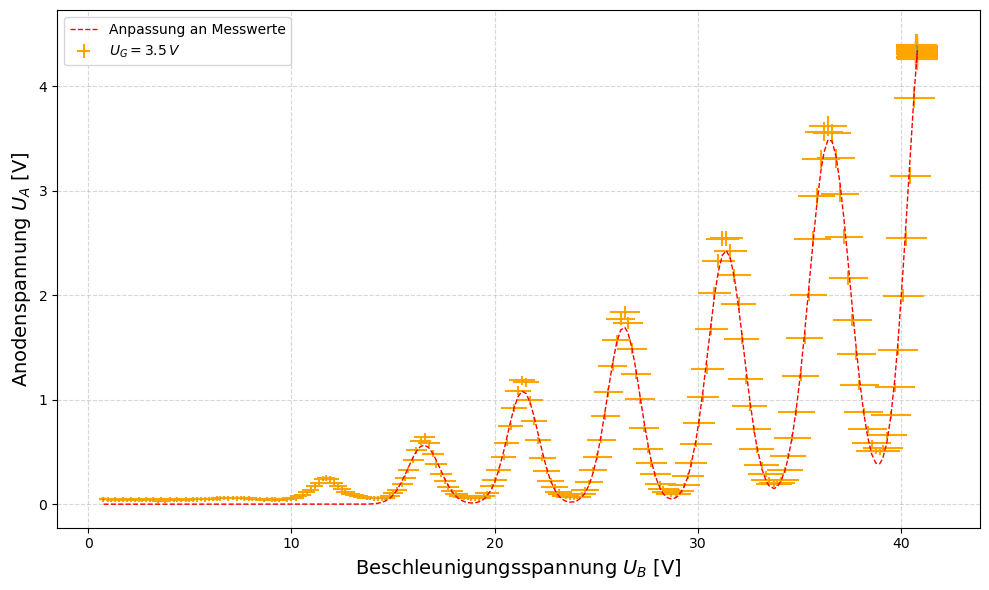

Individual σ values:
  σ_01 = 0.925 V
  σ_02 = 1.000 V
  σ_03 = 0.885 V
  σ_04 = 0.809 V
  σ_05 = 0.769 V
  σ_06 = 0.787 V

Mean σ = 0.862 V
Std. dev. of σ = 0.082 V

Peak spacings ΔU_B_A2_5 between successive centers:
  ΔU_01 = 4.800 V
  ΔU_02 = 5.050 V
  ΔU_03 = 5.000 V
  ΔU_04 = 5.000 V
  ΔU_05 = 4.350 V

Mean ΔU_B_A2_5 = 4.840 V
Std. dev. ΔU_B_A2_5 = 0.260 V

ΔE_A2_5 = 7.755e-19 J = 4.840 eV
Std. dev. ΔE_A2_5 = 4.159e-20 J = 0.260 eV
THIS IS FOR 3.5V


In [154]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from lmfit.models import GaussianModel

# 1) Load your data (custom naming)
dataA3 = np.loadtxt('A_40V_3_5V_165C.txt', skiprows = 5)


UB_A2_5 = dataA3[:, 2]   # "Acceleration voltage" U_B
UA_A2_5 = dataA3[:, 1]   # "Anode voltage"      U_A

# 2) Uncertainties (2% + small floor)
UBerr = 0.02 * UB_A2_5 + 0.005 * np.ptp(UB_A2_5)
UAerr = 0.02 * UA_A2_5 + 0.005 * np.ptp(UA_A2_5)

# 3) Automatically find peaks in the data
peaks, props = find_peaks(UA_A2_5, height=0.1 * UA_A2_5.max(), distance=20)
peak_centers = UB_A2_5[peaks]
peak_amps    = props["peak_heights"]

# 4) Build a sum‐of‐Gaussians model, one Gaussian per detected peak
model = None
params = None
for i, (cen, amp) in enumerate(zip(peak_centers, peak_amps)):
    prefix = f'g{i}_'
    gauss  = GaussianModel(prefix=prefix)
    if model is None:
        model = gauss
        params = gauss.make_params()
    else:
        model += gauss
        params.update(gauss.make_params())

    # initialize and constrain
    params[prefix + 'center'].set(value=cen,   min=cen-0.5, max=cen+0.5)
    params[prefix + 'amplitude'].set(value=amp, min=0)
    params[prefix + 'sigma'].set(value=0.3,   min=0.05, max=1.0)

# 5) Fit with 1/σ weighting → chi-square minimization
weights = 1.0 / UAerr
result  = model.fit(UA_A2_5, params, x=UB_A2_5, weights=weights)

# 6) Plot data + fit
plt.figure(figsize=(10,6))
plt.errorbar(UB_A2_5, UA_A2_5,
             xerr=UBerr, yerr=UAerr,
             fmt='+', ms=0.1, ecolor='orange', alpha=1,
             label=r'$U_G=3.5\,V$')
plt.plot(UB_A2_5, result.best_fit,
         'r--', lw=1, label='Anpassung an Messwerte')
plt.xlabel('Beschleunigungsspannung $U_B$ [V]', fontsize=14)
plt.ylabel('Anodenspannung $U_A$ [V]',        fontsize=14)
#plt.title('Franck–Hertz: Multi‐Gaussian Fit', fontsize=16)
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"UG3_5.png", dpi=1000)
plt.show()

# 7) Extract and report σ's
sigmas = [v for k,v in result.best_values.items() if k.endswith('sigma')]
mean_s, std_s = np.mean(sigmas), np.std(sigmas)
print("Individual σ values:")
for i, s in enumerate(sigmas, 1):
    print(f"  σ_{i:02d} = {s:.3f} V")
print(f"\nMean σ = {mean_s:.3f} V")
print(f"Std. dev. of σ = {std_s:.3f} V")

# 8) Compute successive peak–to–peak spacings ΔU_B, drop any zero‐valued spacing
Delta_U_B_A2_5 = np.diff(peak_centers)
Delta_U_B_A2_5 = Delta_U_B_A2_5[Delta_U_B_A2_5 != 0]  # ignore zero spacings

print("\nPeak spacings ΔU_B_A2_5 between successive centers:")
for i, d in enumerate(Delta_U_B_A2_5, 1):
    print(f"  ΔU_{i:02d} = {d:.3f} V")

# 9) Mean and std deviation of spacing
mean_Delta_U = np.mean(Delta_U_B_A2_5)
std_Delta_U  = np.std(Delta_U_B_A2_5)
print(f"\nMean ΔU_B_A2_5 = {mean_Delta_U:.3f} V")
print(f"Std. dev. ΔU_B_A2_5 = {std_Delta_U:.3f} V")

# 10) Convert to energy
e_charge = 1.602176634e-19  # C
Delta_E_A2_5_J   = e_charge * mean_Delta_U
Std_Delta_E_A2_5_J = e_charge * std_Delta_U
Delta_E_A2_5_eV  = mean_Delta_U        # 1 V × e = 1 eV
Std_Delta_E_A2_5_eV = std_Delta_U

print(f"\nΔE_A2_5 = {Delta_E_A2_5_J:.3e} J = {Delta_E_A2_5_eV:.3f} eV")
print(f"Std. dev. ΔE_A2_5 = {Std_Delta_E_A2_5_J:.3e} J = {Std_Delta_E_A2_5_eV:.3f} eV")

print("THIS IS FOR 3.5V")


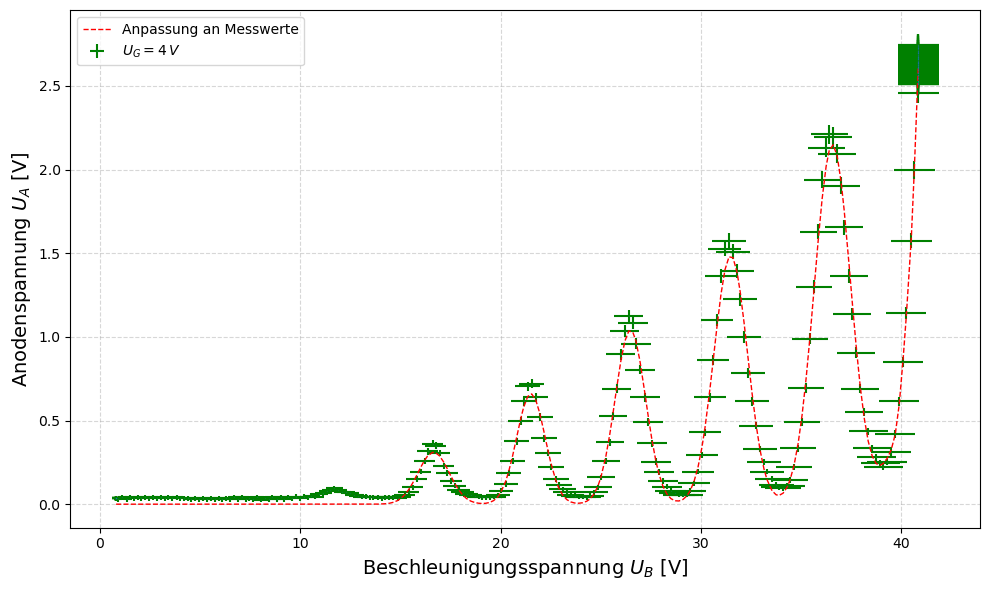

Individual σ values:
  σ_01 = 0.307 V
  σ_02 = 0.334 V
  σ_03 = 1.000 V
  σ_04 = 0.070 V
  σ_05 = 0.911 V
  σ_06 = 0.837 V
  σ_07 = 0.762 V
  σ_08 = 0.710 V
  σ_09 = 0.780 V

Mean σ = 0.635 V
Std. dev. of σ = 0.300 V

Peak spacings ΔU_B_A2_5 between successive centers:
  ΔU_01 = 4.950 V
  ΔU_02 = 4.850 V
  ΔU_03 = 5.000 V
  ΔU_04 = 5.000 V
  ΔU_05 = 4.450 V

Mean ΔU_B_A2_5 = 4.850 V
Std. dev. ΔU_B_A2_5 = 0.207 V

ΔE_A2_5 = 7.771e-19 J = 4.850 eV
Std. dev. ΔE_A2_5 = 3.322e-20 J = 0.207 eV
THIS IS FOR 4V


In [155]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from lmfit.models import GaussianModel

# 1) Load your data (custom naming)
dataA4 = np.loadtxt('A_40V_4V_165C.txt', skiprows = 5)



UB_A2_5 = dataA4[:, 2]   # "Acceleration voltage" U_B
UA_A2_5 = dataA4[:, 1]   # "Anode voltage"      U_A

# 2) Uncertainties (2% + small floor)
UBerr = 0.02 * UB_A2_5 + 0.005 * np.ptp(UB_A2_5)
UAerr = 0.02 * UA_A2_5 + 0.005 * np.ptp(UA_A2_5)

# 3) Automatically find peaks in the data
peaks, props = find_peaks(UA_A2_5, height=0.1 * UA_A2_5.max(), distance=20)
peak_centers = UB_A2_5[peaks]
peak_amps    = props["peak_heights"]

# 4) Build a sum‐of‐Gaussians model, one Gaussian per detected peak
model = None
params = None
for i, (cen, amp) in enumerate(zip(peak_centers, peak_amps)):
    prefix = f'g{i}_'
    gauss  = GaussianModel(prefix=prefix)
    if model is None:
        model = gauss
        params = gauss.make_params()
    else:
        model += gauss
        params.update(gauss.make_params())

    # initialize and constrain
    params[prefix + 'center'].set(value=cen,   min=cen-0.5, max=cen+0.5)
    params[prefix + 'amplitude'].set(value=amp, min=0)
    params[prefix + 'sigma'].set(value=0.3,   min=0.05, max=1.0)

# 5) Fit with 1/σ weighting → chi-square minimization
weights = 1.0 / UAerr
result  = model.fit(UA_A2_5, params, x=UB_A2_5, weights=weights)

# 6) Plot data + fit
plt.figure(figsize=(10,6))
plt.errorbar(UB_A2_5, UA_A2_5,
             xerr=UBerr, yerr=UAerr,
             fmt='+', ms=0.1, ecolor='green', alpha=1,
             label=r'$U_G=4\,V$')
plt.plot(UB_A2_5, result.best_fit,
         'r--', lw=1, label='Anpassung an Messwerte')
plt.xlabel('Beschleunigungsspannung $U_B$ [V]', fontsize=14)
plt.ylabel('Anodenspannung $U_A$ [V]',        fontsize=14)
#plt.title('Franck–Hertz: Multi‐Gaussian Fit', fontsize=16)
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig(f"UG4.png", dpi=1000)
plt.show()

# 7) Extract and report σ's
sigmas = [v for k,v in result.best_values.items() if k.endswith('sigma')]
mean_s, std_s = np.mean(sigmas), np.std(sigmas)
print("Individual σ values:")
for i, s in enumerate(sigmas, 1):
    print(f"  σ_{i:02d} = {s:.3f} V")
print(f"\nMean σ = {mean_s:.3f} V")
print(f"Std. dev. of σ = {std_s:.3f} V")

# 8) Compute successive peak–to–peak spacings ΔU_B, drop any zero‐valued spacing
Delta_U_B_A2_5 = np.diff(peak_centers)
Delta_U_B_A2_5 = Delta_U_B_A2_5[Delta_U_B_A2_5 != 0]  # ignore zero spacings

print("\nPeak spacings ΔU_B_A2_5 between successive centers:")
for i, d in enumerate(Delta_U_B_A2_5, 1):
    print(f"  ΔU_{i:02d} = {d:.3f} V")

# 9) Mean and std deviation of spacing
mean_Delta_U = np.mean(Delta_U_B_A2_5)
std_Delta_U  = np.std(Delta_U_B_A2_5)
print(f"\nMean ΔU_B_A2_5 = {mean_Delta_U:.3f} V")
print(f"Std. dev. ΔU_B_A2_5 = {std_Delta_U:.3f} V")

# 10) Convert to energy
e_charge = 1.602176634e-19  # C
Delta_E_A2_5_J   = e_charge * mean_Delta_U
Std_Delta_E_A2_5_J = e_charge * std_Delta_U
Delta_E_A2_5_eV  = mean_Delta_U        # 1 V × e = 1 eV
Std_Delta_E_A2_5_eV = std_Delta_U

print(f"\nΔE_A2_5 = {Delta_E_A2_5_J:.3e} J = {Delta_E_A2_5_eV:.3f} eV")
print(f"Std. dev. ΔE_A2_5 = {Std_Delta_E_A2_5_J:.3e} J = {Std_Delta_E_A2_5_eV:.3f} eV")

print("THIS IS FOR 4V")